Среднеквадратичная ошибка (MSE): 30.03891854323047


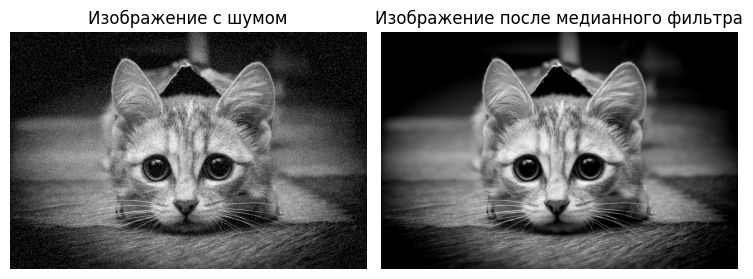

TypeError: Signature mismatch: 1 argument types given, but function takes 3 arguments

In [68]:
import random
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

# Параметры
BASEDIR = "./data"
IMAGE_PATH = os.path.join(BASEDIR, "Kity.jpg")  # Путь к изображению
NOISE_PERCENTAGE = 0.1  # Процент шума

WINDOW_SIZE = 3

# Функция для добавления шума "соль и перец"
def add_noise(img, noise_percentage):
    row, col = img.shape
    total_pixels = row * col
    number_of_noise_pixels = int(total_pixels * noise_percentage)  # Количество пикселей с шумом

    for _ in range(number_of_noise_pixels // 2):
        y_coord = random.randint(0, row - 1)
        x_coord = random.randint(0, col - 1)
        img[y_coord][x_coord] = 255  # белый пиксель

    for _ in range(number_of_noise_pixels // 2):
        y_coord = random.randint(0, row - 1)
        x_coord = random.randint(0, col - 1)
        img[y_coord][x_coord] = 0  # черный пиксель

    return img

# Функция для медианного фильтра
def median_filter_cpu(input_image: np.array, window_size=WINDOW_SIZE) -> np.array:
    height, width = input_image.shape
    mask = []
    counter = window_size // 2
    out_image = np.zeros((height, width))

    for x in range(height):
        for y in range(width):
            for i in range(window_size):
                if x + i - counter < 0 or x + i - counter > height - 1:
                    for j in range(window_size):
                        mask.append(0)
                else:
                    if y + i - counter < 0 or y + counter > width - 1:
                        mask.append(0)
                    else:
                        for j in range(window_size):
                            mask.append(input_image[x + i - counter][y + j - counter])

            mask.sort()
            out_image[x][y] = mask[len(mask) // 2]
            mask = []
    return out_image

# Функция для расчета MSE
def calculate_mse(original, filtered):
    return np.mean((original - filtered) ** 2)

# Основной код
if not os.path.exists(BASEDIR):
    os.makedirs(BASEDIR)

# Загружаем изображение
img = cv2.imread(IMAGE_PATH, cv2.IMREAD_GRAYSCALE)

if img is None:
    print("Ошибка: не удалось загрузить изображение. Проверьте путь к файлу.")
    exit()

# Добавление шума
noisy_img = add_noise(img.copy(), NOISE_PERCENTAGE)
cv2.imwrite(os.path.join(BASEDIR, "noisy_image.jpg"), noisy_img)

# Применение медианного фильтра
filtered_img = median_filter_cpu(noisy_img)
cv2.imwrite(os.path.join(BASEDIR, "filtered_image.jpg"), filtered_img)

# Расчет MSE
mse_value = calculate_mse(img, filtered_img)
print(f"Среднеквадратичная ошибка (MSE): {mse_value}")

# Построение графиков
plt.figure(figsize=(15, 5))


plt.subplot(1, 4, 2)
plt.title("Изображение с шумом")
plt.imshow(noisy_img, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title("Изображение после медианного фильтра")
plt.imshow(filtered_img, cmap='gray')
plt.axis('off')


plt.tight_layout()
plt.show()# Параметры
BASEDIR = "./data"
IMAGE_PATH = os.path.join(BASEDIR, "Kity.jpg")  # Путь к изображению
NOISE_PERCENTAGE = 0.3  # Процент шума
WINDOW_SIZE = 3

# Функция для добавления шума "соль и перец"
def add_noise(img, noise_percentage):
    row, col = img.shape
    total_pixels = row * col
    number_of_noise_pixels = int(total_pixels * noise_percentage)  # Количество пикселей с шумом

    for _ in range(number_of_noise_pixels // 2):
        y_coord = random.randint(0, row - 1)
        x_coord = random.randint(0, col - 1)
        img[y_coord][x_coord] = 255  # белый пиксель

    for _ in range(number_of_noise_pixels // 2):
        y_coord = random.randint(0, row - 1)
        x_coord = random.randint(0, col - 1)
        img[y_coord][x_coord] = 0  # черный пиксель

    return img

# Функция для медианного фильтра на GPU
@cuda.jit
def median_filter_gpu(input_image, output_image, window_size):
    # Вычисление индекса текущего потока
    x, y = cuda.grid(2)
    height, width = input_image.shape
    pad = window_size // 2

    # Проверка границ изображения
    if x >= height or y >= width:
        return

    # Сборка окна
    window = []
    for dx in range(-pad, pad + 1):
        for dy in range(-pad, pad + 1):
            nx, ny = x + dx, y + dy
            if 0 <= nx < height and 0 <= ny < width:
                window.append(input_image[nx, ny])

    # Сортировка и нахождение медианы
    window.sort()
    output_image[x, y] = window[len(window) // 2]

# Функция для расчёта MSE
def calculate_mse(original, filtered):
    return np.mean((original - filtered) ** 2)

# Основной код
if not os.path.exists(BASEDIR):
    os.makedirs(BASEDIR)

# Загружаем изображение
img = cv2.imread(IMAGE_PATH, cv2.IMREAD_GRAYSCALE)

if img is None:
    print("Ошибка: не удалось загрузить изображение. Проверьте путь к файлу.")
    exit()

# Добавление шума
noisy_img = add_noise(img.copy(), NOISE_PERCENTAGE)
cv2.imwrite(os.path.join(BASEDIR, "noisy_image.jpg"), noisy_img)

# Преобразование изображения в формат для GPU
height, width = noisy_img.shape
input_image_gpu = cuda.to_device(noisy_img)
output_image_gpu = cuda.device_array_like(noisy_img)

# Настройка сетки и блоков
threads_per_block = (16, 16)
blocks_per_grid_x = (height + threads_per_block[0] - 1) // threads_per_block[0]
blocks_per_grid_y = (width + threads_per_block[1] - 1) // threads_per_block[1]
blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

# Применение медианного фильтра на GPU
start_time = time.time()
median_filter_gpu[blocks_per_grid, threads_per_block](input_image_gpu, output_image_gpu, WINDOW_SIZE)
cuda.synchronize()
end_time = time.time()

# Копирование результата обратно на CPU
filtered_img_gpu = output_image_gpu.copy_to_host()

# Расчёт MSE
mse_value = calculate_mse(img, filtered_img_gpu)
print(f"Среднеквадратичная ошибка (MSE): {mse_value}")

# Время выполнения
execution_time = end_time - start_time
print(f"Время выполнения медианного фильтра на GPU: {execution_time:.4f} секунд")

# Построение графиков
plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 2)
plt.title("Изображение с шумом")
plt.imshow(noisy_img, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title("Изображение после медианного (GPU)")
plt.imshow(filtered_img_gpu, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


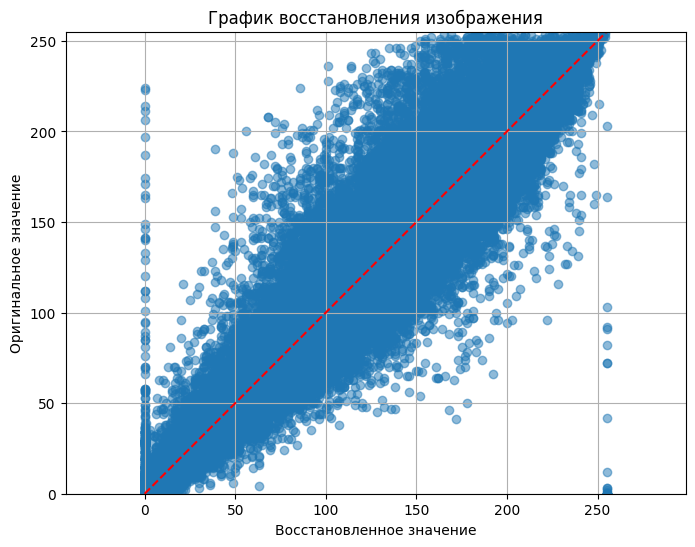

In [70]:
# График восстановления
plt.figure(figsize=(8, 6))
plt.title("График восстановления изображения")
plt.scatter(filtered_img.flatten(), img.flatten(), alpha=0.5)
plt.plot([0, 255], [0, 255], 'r--')  # Линия идеального восстановления
plt.xlabel("Восстановленное значение")
plt.ylabel("Оригинальное значение")
plt.axis('equal')
plt.xlim(0, 255)
plt.ylim(0, 255)
plt.grid()
plt.show()